## Fine-Tuning with Pegasus

#### trainrf on many different datasets (not just news with rather long GT summaries)


@misc{zhang2019pegasus,
    title={PEGASUS: Pre-training with Extracted Gap-sentences for Abstractive Summarization},
    author={Jingqing Zhang and Yao Zhao and Mohammad Saleh and Peter J. Liu},
    year={2019},
    eprint={1912.08777},
    archivePrefix={arXiv},
    primaryClass={cs.CL}
}


In [ ]:
!pip install transformers
!pip install huggingface
!pip install accelerate
!pip install rouge_score
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 88.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 98.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 14.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=b393eaf5acb7c4b355961d2c6ac5907dc9f205a8dd0ef00818740533210878b0
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e

In [ ]:
## important all needed packages
import transformers
import huggingface
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from google.colab import drive
from transformers import pipeline
from transformers import DataCollatorForSeq2Seq
from torch.utils.data import DataLoader
import evaluate
from tqdm.auto import tqdm
import torch
import numpy as np
import nltk
from torch.optim import AdamW
from accelerate import Accelerator
from transformers import get_scheduler
import matplotlib.pyplot as plt

## further downloads
nltk.download('punkt')
rouge_score = evaluate.load("rouge")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#### functions ####

## Code for all functions to be called in later

def preprocess_function(input):

    """
    This function applies the tokenizer to both
    the descriptons and the names.
    max_input_length: Maximum length of tokens in input (description ) - to be defined globally
    max_target_length: Maximum number of tokens in output (title) - to be defined globally
    """

    model_inputs = tokenizer(
        input["description"],
        max_length=max_input_length,
        truncation=True,
    )
    labels = tokenizer(
        input["name"], max_length=max_target_length, truncation=True   ## truncate to maximum length
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs




## function to process data so that it can be used in the finetuning


def prepare_data(airbnb_london_filtered_advanced, frac_train_size, batch_size):

  """
  This function prepares the data for the subsequent fine-tuning.
  First Input: Dataset (as loaded from Drive)
  frac_train_size: fraction to be used in training
  batch_size: Batch size to be used in preparing the DataLoaders
  """

  train_eval_airbnb_london_filtered_advanced = airbnb_london_filtered_advanced[airbnb_london_filtered_advanced.in_top_third == 1]

  train_airbnb_london_filtered_advanced = train_eval_airbnb_london_filtered_advanced.sample(n = int(np.ceil(frac_train_size*train_eval_airbnb_london_filtered_advanced.shape[0])), random_state = 123)
  eval_airbnb_london_filtered_advanced = train_eval_airbnb_london_filtered_advanced.drop(train_airbnb_london_filtered_advanced.index, axis = 0)


  ## re-setting the index, else looping through dataloaders results in erros: https://discuss.pytorch.org/t/keyerror-when-enumerating-over-dataloader/54210/8
  train_airbnb_london_filtered_advanced.index = list(range(train_airbnb_london_filtered_advanced.shape[0]))
  eval_airbnb_london_filtered_advanced.index = list(range(eval_airbnb_london_filtered_advanced.shape[0]))


  # tokenized_datasets
  tokenized_datasets  = train_airbnb_london_filtered_advanced.apply(preprocess_function, axis = 1)

  # eval_tokenized_datasets
  eval_tokenized_datasets  = eval_airbnb_london_filtered_advanced.apply(preprocess_function, axis = 1)

  ## calling data loader
  #batch_size = 8

  train_dataloader = DataLoader(
      tokenized_datasets,
      shuffle=True,
      collate_fn=data_collator,
      batch_size=batch_size,
  )

  eval_dataloader = DataLoader(
      eval_tokenized_datasets,
  #   shuffle=True,
      collate_fn=data_collator,
      batch_size=batch_size
  )

  return train_dataloader, eval_dataloader


def postprocess_text(preds, labels):

    """
    Post-processing to prepare inputs to the ROGUE functions
    """
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # ROUGE expects a newline after each sentence
    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels


def preprocess_rogue(input_ids, attention_mask, labels):

  """
  Requires in input_ids and att_masks
  - Model needs to have been called.
  """
  generated_tokens = accelerator.unwrap_model(model).generate(input_ids=input_ids, attention_mask=attention_mask)

  # apply padding
  padded_generated_tokens = accelerator.pad_across_processes( generated_tokens, dim=1, pad_index=tokenizer.pad_token_id)

  # labels to cpu
  labels = labels.cpu().numpy()

  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  if isinstance(padded_generated_tokens, tuple):
    padded_generated_tokens = padded_generated_tokens[0]
  decoded_preds = tokenizer.batch_decode( padded_generated_tokens, skip_special_tokens=True )
  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  decoded_preds, decoded_labels = postprocess_text( decoded_preds, decoded_labels)

  return decoded_preds, decoded_labels





In [ ]:
### downloading model

model_path = "google/pegasus-xsum"

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)

In [ ]:

# connecting to drive

drive.mount('/content/gdrive')
airbnb_london_filtered_advanced = pd.read_csv("/content/gdrive/My Drive/Thesis/London_Data/airbnb_london_filtered_advanced.csv")


Mounted at /content/gdrive


<ipython-input-3-fd0df36ad2e1>:4: DtypeWarning: Columns (3,22,41,45,46,61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  airbnb_london_filtered_advanced = pd.read_csv("/content/gdrive/My Drive/Thesis/London_Data/airbnb_london_filtered_advanced.csv")


In [ ]:
## preparing the training

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)
optimizer = AdamW(model.parameters(), lr=2e-5)


In [ ]:
frac_train_size = 0.7
batch_size = 8
max_input_length = 512
max_target_length = 15


train_dataloader, eval_dataloader = prepare_data(airbnb_london_filtered_advanced, frac_train_size, batch_size)


In [ ]:

accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

In [ ]:
### Setting up dynamic learning rate scheduler ###

# before the sheduler is called, a few clarifications:

# len(train_dataloader) denotes the amount of batches per training set.
# the var 'num_training_steps' denotes that times the epochs. This is important for the tqdm update bar

# the loss should be saved
   # 1) per training step
   # 2) per epoch


num_train_epochs = 7       ### first only 5 to try out !!


num_update_steps_per_epoch = len(train_dataloader)
num_eval_steps_per_epoch = len(eval_dataloader)

num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,     ## one might also alter this!
    num_training_steps=num_training_steps,
)

In [ ]:
## using GPU

device = 'cuda'
model = model.to(device)

In [ ]:
## computing rouge scores prioir to fine-tuning
rouge_score = evaluate.load("rouge")

model.eval()

for batch in eval_dataloader:
  with torch.no_grad():

    input_ids = torch.tensor(batch.input_ids).to(device)
    attention_mask = torch.tensor(batch.attention_mask).to(device)
    labels = torch.tensor(batch.labels).to(device)

    # calculating rogue_scores
    decoded_preds, decoded_labels = preprocess_rogue(input_ids, attention_mask, labels)

    ## computing rogue scores
    rouge_score.add_batch(predictions=decoded_preds, references=decoded_labels)


result = rouge_score.compute()

print("The ROUGE metrics on the evaluation data prior to fine-tuning are:")
print(f'     F1 - ROUGE-1: {np.round(result["rouge1"],4)}.')
print(f'     F1 - ROUGE-2: {np.round(result["rouge2"],4)}.')
print(f'     F1 - ROUGE-L: {np.round(result["rougeL"],4)}.')


You're using a PegasusTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
<ipython-input-12-38211cccfc65>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(batch.input_ids).to(device)
<ipython-input-12-38211cccfc65>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(batch.attention_mask).to(device)
<ipython-input-12-38211cccfc65>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

The ROUGE metrics on the evaluation data prior to fine-tuning are:
     F1 - ROUGE-1: 0.1472.
     F1 - ROUGE-2: 0.0384.
     F1 - ROUGE-L: 0.1366.


In [ ]:
rouge_score = evaluate.load("rouge")

progress_bar = tqdm(range(num_training_steps))

# initiating lists for the losses
losses_per_epoch = []
losses_per_training_step = []

eval_losses_per_epoch = []
eval_losses_per_training_step = []


for epoch in range(num_train_epochs):


  ### kick-starting the actual training ###

  model.train()

  for batch in train_dataloader:

    input_ids = torch.tensor(batch.input_ids).to(device)
    attention_mask = torch.tensor(batch.attention_mask).to(device)
    labels = torch.tensor(batch.labels).to(device)   ## this essential for automatic computation of loss ??
    ## yes - mention automatic computation of  auto-regressive CE-Loss of on each token

    outputs = model(input_ids = input_ids, attention_mask = attention_mask, labels = labels )   ## **batch

    # update of loss
    loss = outputs.loss
    accelerator.backward(loss)
    losses_per_training_step.append( outputs.loss.item() )

    # backprop
    optimizer.step()
    lr_scheduler.step()
    optimizer.zero_grad()
    progress_bar.update(1)


  # mean loss per epoch
  latest_loss_per_epoch = np.mean(losses_per_training_step[len(losses_per_training_step)- num_update_steps_per_epoch: ]) # losses per last epoch
  losses_per_epoch.append(latest_loss_per_epoch)

  ### evaluation

  model.eval()

  for batch in eval_dataloader:

    with torch.no_grad():


      input_ids = torch.tensor(batch.input_ids).to(device)
      attention_mask = torch.tensor(batch.attention_mask).to(device)
      labels = torch.tensor(batch.labels).to(device)

      outputs = model(input_ids = input_ids, attention_mask = attention_mask, labels = labels )   ## **batch

      loss = outputs.loss
      eval_losses_per_training_step.append( outputs.loss.item() )

      if epoch == num_train_epochs -1 :


        # calculating rogue_scores
        decoded_preds, decoded_labels = preprocess_rogue(input_ids, attention_mask, labels)


        ## computing rogue scores  - hier ggf noch abändern!
        rouge_score.add_batch(predictions=decoded_preds, references=decoded_labels)

  result = rouge_score.compute()


  # mean loss per epoch
  latest_loss_per_epoch = np.mean(eval_losses_per_training_step[len(eval_losses_per_training_step)- num_eval_steps_per_epoch: ]) # losses per last epoch
  eval_losses_per_epoch.append(latest_loss_per_epoch)


  0%|          | 0/6083 [00:00<?, ?it/s]

You're using a PegasusTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
<ipython-input-12-764cf4078a39>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(batch.input_ids).to(device)
<ipython-input-12-764cf4078a39>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(batch.attention_mask).to(device)
<ipython-input-12-764cf4078a39>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tr

In [ ]:
print("The ROUGE metrics on the evaluation data AFTER the fine-tuning are:")
print(f'     F1 - ROUGE-1: {np.round(result["rouge1"],4)}.')
print(f'     F1 - ROUGE-2: {np.round(result["rouge2"],4)}.')
print(f'     F1 - ROUGE-L: {np.round(result["rougeL"],4)}.')

The ROUGE metrics on the evaluation data AFTER the fine-tuning are:
     F1 - ROUGE-1: 0.2353.
     F1 - ROUGE-2: 0.0.
     F1 - ROUGE-L: 0.2353.


In [ ]:
## saving  losses

name_to_save = "losses_pegasus"
df_losses_1 = pd.DataFrame({"loss_eval": eval_losses_per_epoch, "loss_train": losses_per_epoch })
df_losses_1.to_csv(f"/content/gdrive/My Drive/Thesis/loss_data/{name_to_save}.csv")


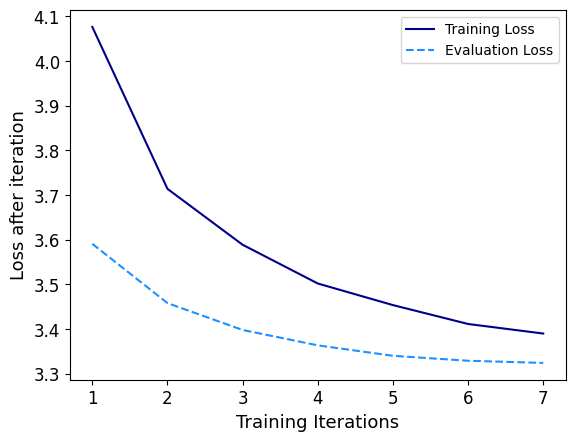

In [ ]:
# over  epochs
epochs = list(range(1,num_train_epochs+1))
name_to_save = "losses_pegasus"

plt.plot(epochs, losses_per_epoch, color = "darkblue")
plt.plot(epochs, eval_losses_per_epoch, color = "dodgerblue", linestyle='dashed')
plt.legend(["Training Loss", "Evaluation Loss"], loc='upper right')
plt.xlabel("Training Iterations", fontsize=13)
plt.ylabel("Loss after iteration", fontsize=13)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig(f'/content/gdrive/My Drive/Thesis/Plots/{name_to_save}.png')
plt.show()



In [ ]:
#saving the model
model_save_name = 'pegasus_fine_tuned_1.pth'


path ="/content/gdrive/My Drive/Thesis/Models/{}".format(model_save_name)
torch.save(model, path)


In [ ]:
model_save_name = 'pegasus_fine_tuned_1.pth'
path ="/content/gdrive/My Drive/Thesis/Models/{}".format(model_save_name)

model2 = torch.load(path, map_location=torch.device('cpu'))
#model2 = model2.to('cpu')


#### Printing out examples of generated titles after fine-tuning on train and eval sets:

In [ ]:

model_path = "google/pegasus-xsum"
tokenizer = AutoTokenizer.from_pretrained(model_path)

summarizer = pipeline("summarization", model=model2, tokenizer = tokenizer)


In [ ]:
train_eval_airbnb_london_filtered_advanced = airbnb_london_filtered_advanced[airbnb_london_filtered_advanced.in_top_third == 1]
frac_train_size = 0.7
train_airbnb_london_filtered_advanced = train_eval_airbnb_london_filtered_advanced.sample(n = int(np.ceil(frac_train_size*train_eval_airbnb_london_filtered_advanced.shape[0])), random_state = 123)
eval_airbnb_london_filtered_advanced = train_eval_airbnb_london_filtered_advanced.drop(train_airbnb_london_filtered_advanced.index, axis = 0)


In [ ]:
## for the training set

for i,j in enumerate(train_airbnb_london_filtered_advanced.index[:12]):
  print(i)
  print(f'The ground truth text is: {train_airbnb_london_filtered_advanced.name[j]}.')
  print( summarizer(train_airbnb_london_filtered_advanced.description[j], min_length=5, max_length=25) )
  print("------------------------------------------------------------")

0
The ground truth text is: Bright room in quiet LGBT Home.
[{'summary_text': 'Bright & airy, quiet flat in Lewisham'}]
------------------------------------------------------------
1
The ground truth text is: Room in Regents Park Flat.
[{'summary_text': 'Double Room in Central London'}]
------------------------------------------------------------
2
The ground truth text is: Single room in 1 bedroom flat in Thamesmead.
[{'summary_text': 'Cosy single room in a shared flat'}]
------------------------------------------------------------
3
The ground truth text is: Bright Twin Room in Victorian house /Zone 2.
[{'summary_text': 'Double Room in Brockley Conservation Area'}]
------------------------------------------------------------
4
The ground truth text is: Double bedroom  in spacious warehouse apartment.
[{'summary_text': 'Double room in Hackney Downs warehouse apartment'}]
------------------------------------------------------------
5
The ground truth text is: Cosy Wimbledon Flat for Fa

In [ ]:
## for the eval set

for i,j in enumerate(eval_airbnb_london_filtered_advanced.index[:12]):
  print(i)
  print(f'The ground truth text is: {eval_airbnb_london_filtered_advanced.name[j]}.')
  print( summarizer(eval_airbnb_london_filtered_advanced.description[j], min_length=5, max_length=25) )
  print("------------------------------------------------------------")

0
The ground truth text is: Holiday London DB Room Let-on going.
[{'summary_text': 'Lovely double bedroom in Finsbury Park'}]
------------------------------------------------------------
1
The ground truth text is: Superb 3-Bed/2 Bath & Wifi: Trendy W1.
[{'summary_text': 'Modern Fitzrovia Apartment with Elevator'}]
------------------------------------------------------------
2
The ground truth text is: ✦Bright Top Floor Sunset View Modern Chelsea apt✦.
[{'summary_text': 'Lovely 2bed flat in the heart of Imperial Wharf'}]
------------------------------------------------------------
3
The ground truth text is: Cosy Double studio in Zone 2 Hammersmith (2).
[{'summary_text': 'Studio in the heart of Hammersmith'}]
------------------------------------------------------------
4
The ground truth text is: West London-W7, Hanwell (Area Ealing) Room.
[{'summary_text': 'Genuinely Friendly 3 bed flat in Ealing'}]
------------------------------------------------------------
5
The ground truth text i

In [ ]:
name_save = "gen_titles_pegasus"
list_titles_df = pd.read_csv(f"/content/gdrive/My Drive/Thesis/loss_data/{name_save}.csv")


In [ ]:
list_titles_df.head()

,ids,gen_titles
0,13913,Lovely double bedroom in Finsbury Park
1,17402,Modern Fitzrovia Apartment with Elevator
2,25123,Large double room in Golders Green
3,36299,3 Bed House with garden close to Thames river
4,39387,Private lockable room in bright flat


In [ ]:
list_titles = list(list_titles_df.gen_titles)
ids_list = list(list_titles_df.ids)

In [ ]:
#list_titles = []
#ids_list = []
name_save = "gen_titles_pegasus"

for i in range(len(list_titles), airbnb_london_filtered_advanced.shape[0]):
#  print(i/airbnb_london_filtered_advanced.shape[0])
  gen_title = summarizer(airbnb_london_filtered_advanced.description[i], min_length=5, max_length=25)
  list_titles.append(gen_title[0]['summary_text'])
  ids_list.append(airbnb_london_filtered_advanced.id[i])
  if i % 150 == 0:
    list_titles_df = pd.DataFrame({"ids": ids_list, "gen_titles": list_titles})
    list_titles_df.to_csv(f"/content/gdrive/My Drive/Thesis/loss_data/{name_save}.csv", index = False)

name_save = "gen_titles_pegasus"
list_titles_df = pd.DataFrame({"ids": ids_list, "gen_titles": list_titles})
list_titles_df.to_csv(f"/content/gdrive/My Drive/Thesis/loss_data/{name_save}.csv", index = False)


In [ ]:
#name_save = "gen_titles_pegasus"
#list_titles_df = pd.DataFrame({"ids": ids_list, "gen_titles": list_titles})
#list_titles_df.to_csv(f"/content/gdrive/My Drive/Thesis/loss_data/{name_save}.csv", index = False)